In [ ]:
!pip install requests beautifulsoup4 pandas tabulate matplotlib kiwipiepy JPype1

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from kiwipiepy import Kiwi
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
from tabulate import tabulate
import matplotlib.pyplot as plt

In [ ]:
url_list = [
    "https://n.news.naver.com/mnews/article/003/0012509031?sid=104",
    "https://n.news.naver.com/mnews/article/123/0002261234?sid=101",
    "https://n.news.naver.com/article/081/0003449775?sid=100",
    "https://n.news.naver.com/mnews/article/586/0000071669?sid=102",
    "https://n.news.naver.com/mnews/article/011/0004234555?sid=104",
    "https://n.news.naver.com/article/015/0004984365?sid=105",
    "https://n.news.naver.com/mnews/article/277/0005150997?sid=101",
    "https://n.news.naver.com/mnews/article/366/0000776450?sid=104",
    "https://n.news.naver.com/mnews/article/018/0005071379?sid=103",
    "https://n.news.naver.com/mnews/article/005/0001599840?sid=104",
    "https://n.news.naver.com/mnews/article/020/0003561471?sid=102",
    "https://n.news.naver.com/mnews/article/081/0003449775?sid=100",
    "https://n.news.naver.com/mnews/article/023/0003684234?sid=104",
    "https://n.news.naver.com/mnews/article/081/0003197375?sid=103",
    "https://n.news.naver.com/mnews/article/055/0001058068?sid=102",
    "https://n.news.naver.com/mnews/article/001/0014691388?sid=104",
    "https://n.news.naver.com/article/081/0003449775?sid=100",
    "https://n.news.naver.com/mnews/article/666/0000008525?sid=102",
    "https://n.news.naver.com/mnews/article/421/0004956937?sid=103",
    "https://n.news.naver.com/mnews/article/008/0004739154?sid=105",
    "https://n.news.naver.com/mnews/article/009/0005044534?sid=101",
    "https://n.news.naver.com/mnews/article/277/0004502360?sid=104",
    "https://n.news.naver.com/mnews/article/001/0014381692?sid=105",
    "https://n.news.naver.com/mnews/article/214/0001347387?sid=102",
    "https://n.news.naver.com/article/005/0001696904?sid=100",
    "https://n.news.naver.com/mnews/article/028/0002623459?sid=101",
    "https://n.news.naver.com/mnews/article/028/0002623459?sid=101",
    "https://n.news.naver.com/mnews/article/277/0005150997?sid=101",
    "https://n.news.naver.com/mnews/article/001/0013152100?sid=103",
    "https://n.news.naver.com/mnews/article/003/0012224769?sid=102",
    "https://n.news.naver.com/mnews/article/008/0005039595?sid=102",
    "https://n.news.naver.com/article/417/0001002901?sid=100",
    "https://n.news.naver.com/mnews/article/032/0003056437?sid=104",
    "https://n.news.naver.com/mnews/article/030/0003061278?sid=105",
    "https://n.news.naver.com/article/003/0012509031?sid=100",
    "https://n.news.naver.com/mnews/article/011/0004219987?sid=102",
    "https://n.news.naver.com/mnews/article/008/0005003270?sid=105",
    "https://n.news.naver.com/mnews/article/003/0010412100?sid=103",
    "https://n.news.naver.com/mnews/article/009/0005305248",
    "https://n.news.naver.com/mnews/article/009/0005044534?sid=101",
    "https://n.news.naver.com/mnews/article/031/0000729190?sid=105",
    "https://n.news.naver.com/mnews/article/421/0005153763?sid=104",
    "https://n.news.naver.com/mnews/article/028/0002623459?sid=101",
    "https://n.news.naver.com/mnews/article/422/0000369319?sid=103",
    "https://n.news.naver.com/mnews/article/056/0011723764?sid=102",
    "https://n.news.naver.com/mnews/article/047/0002337515?sid=104"
]

# 카테고리 매핑
category_mapping = {
    '100': 'Politics',
    '101': 'Economy',
    '102': 'Society',
    '103': 'Culture',
    '104': 'World',
    '105': 'IT/Science'
}

# 뉴스사별 기본 카테고리 매핑 (예제, 실제로는 더 많은 뉴스사 ID가 필요할 수 있음)
news_category_mapping = {
    '009': 'Politics',
    '448': 'Politics',
    '421': 'Politics',
}

def get_category_from_url(url):
    # URL에서 sid 매개변수를 추출
    if "sid=" in url:
        sid = url.split("sid=")[-1][:3]  # sid는 항상 3자리 숫자
        return category_mapping.get(sid, "Unknown")
    else:
        # 다른 형식의 URL에서 기사 ID 추출
        article_id = url.split('/article/')[1].split('/')[0]
        return news_category_mapping.get(article_id, "Unknown")

def extract_title(soup):
    title = None

    # 제목 추출 시도 1: og:title 메타 태그
    meta_tag = soup.find('meta', property='og:title')
    if meta_tag:
        title = meta_tag.get('content')

    # 제목 추출 시도 2: 네이버 뉴스 기본 제목 태그
    if not title:
        headline_tag = soup.find('h2', {'class': 'media_end_head_headline'})
        if headline_tag:
            title = headline_tag.text.strip()

    # 제목 추출 시도 3: 네이버 엔터테인먼트 제목 태그
    if not title:
        headline_tag_ent = soup.find('h1', {'class': 'tit'})
        if headline_tag_ent:
            title = headline_tag_ent.text.strip()

    # 제목 추출 시도 4: 네이버 뉴스 대체 제목 태그
    if not title:
        headline_tag_alt = soup.find('h3', {'id': 'articleTitle'})
        if headline_tag_alt:
            title = headline_tag_alt.text.strip()

    # 제목 추출 시도 5: 일반적인 제목 태그
    if not title:
        title_tag = soup.find('title')
        if title_tag:
            title = title_tag.text.strip().replace('\n', '')

    return title

def extract_content(soup):
    content = None

    # 본문 추출 시도 1: id가 dic_area인 div
    content_tag = soup.find('div', {'id': 'dic_area'})
    if not content_tag:
        # 본문 추출 시도 2: class가 newsct_article인 div
        content_tag = soup.find('div', {'class': 'newsct_article'})
    if not content_tag:
        # 본문 추출 시도 3: 여러 p 태그를 포함하는 div
        content_tag = soup.find('div', {'class': 'news_end'})
    if content_tag:
        content = content_tag.get_text(separator='\n', strip=True)
    else:
        content = "Article content not found."

    return content

def extract_date(soup):
    date = None

    # 날짜 추출 시도 1: og:article:published_time 메타 태그
    meta_tag = soup.find('meta', property='og:article:published_time')
    if meta_tag:
        date = meta_tag.get('content')

    # 날짜 추출 시도 2: 네이버 뉴스 기본 날짜 태그
    if not date:
        date_tag = soup.find('span', {'class': 'media_end_head_info_datestamp_time'})
        if date_tag:
            date = date_tag.text.strip()

    # 날짜 추출 시도 3: 네이버 뉴스 대체 날짜 태그
    if not date:
        date_tag_alt = soup.find('span', {'class': 't11'})
        if date_tag_alt:
            date = date_tag_alt.text.strip()

    return date

# 각 URL에서 데이터를 추출하여 두 개의 리스트에 저장
metadata_list = []
content_date_list = []
titles_seen = set()

for url in url_list:
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    category = get_category_from_url(url)
    title = extract_title(soup)
    content = extract_content(soup)
    date = extract_date(soup)

    if title and "뉴스 : 네이버" not in title:
        if title not in titles_seen:
            metadata_list.append({'url': url, 'category': category, 'title': title})
            content_date_list.append({'content': content, 'date': date})
            titles_seen.add(title)
    else:
        if '제목을 찾을 수 없음' not in titles_seen:
            metadata_list.append({'url': url, 'category': category, 'title': '제목을 찾을 수 없음'})
            content_date_list.append({'content': '본문을 찾을 수 없음', 'date': '날짜를 찾을 수 없음'})
            titles_seen.add('제목을 찾을 수 없음')

# 데이터프레임으로 변환
metadata_df = pd.DataFrame(metadata_list)
content_date_df = pd.DataFrame(content_date_list)

# pandas 출력 옵션 설정
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

# 메타데이터 데이터프레임 출력
print("Metadata DataFrame")
print(metadata_df)

# 본문과 날짜를 함께 포맷팅하여 출력, 본문 길이를 150자로 고정하고 날짜를 맞추기
print("\nContent and Date DataFrame")
content_date_df['content'] = content_date_df['content'].apply(lambda x: x[:300] if len(x) > 300 else x)
print(content_date_df[['content']])



Metadata DataFrame
                                                              url    category                                      title
0   https://n.news.naver.com/mnews/article/003/0012509031?sid=104       World             "돈주고 불리한 기사 막았다" 트럼프 성추문 재판 증언
1   https://n.news.naver.com/mnews/article/123/0002261234?sid=101     Economy        오미크론 돌파감염, 백신효과 없나?..."중증예방 효과는 유지"
2         https://n.news.naver.com/article/081/0003449775?sid=100    Politics          윤 대통령 “아내 처신으로 걱정 끼쳐 사과…특검은 정치공세”
3   https://n.news.naver.com/mnews/article/586/0000071669?sid=102     Society           20분 만에 떠난 尹-韓…"왜 왔나" 서천시장 상인들 분노
4   https://n.news.naver.com/mnews/article/011/0004234555?sid=104       World                       연천군 종합장사시설 설치 후보지 공모
5         https://n.news.naver.com/article/015/0004984365?sid=105  IT/Science        영화 'Her' 현실로…사람처럼 감정 담아 대화하는 AI 나온다
6   https://n.news.naver.com/mnews/article/277/0005150997?sid=101     Economy               오뚜기, '스타트업 오픈 스테이지' 참가 기업 모집
7   https://n

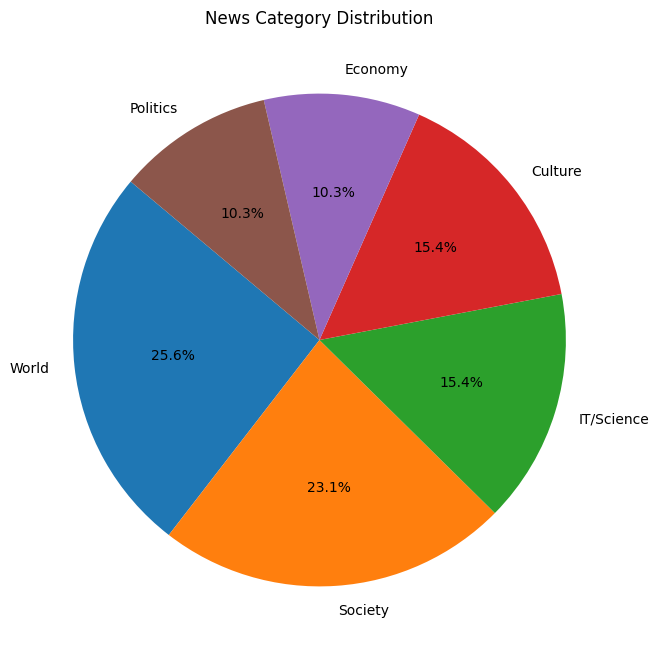

In [ ]:
# 카테고리 분포를 시각화하기 위해 원 그래프 생성
category_counts = metadata_df['category'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('News Category Distribution')
plt.show()


In [ ]:
from kiwipiepy import Kiwi
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

kiwi = Kiwi()

def text_to_sentences(text):
    sentences = kiwi.split_into_sents(text)
    return [sentence.text for sentence in sentences]

stopwords = ['머니투데이', '연합뉴스', '데일리', '동아일보', '중앙일보', '조선일보', '기자', '야', '뉴스1', '아이고', '아이구',
             '아이쿠', '어', '나', '우리', '저희', '따라', '의해', '를', '을', '의', '여기',
             '에', '가', '이', '그', '저', '것', '수', '등', '들', '및', '와', '한', '하다', '뉴시스']

def get_nouns(sentences):
    nouns = []
    for sentence in sentences:
        if sentence:
            tokens = kiwi.tokenize(sentence)
            nouns.append(' '.join([token.form for token in tokens if token.tag.startswith('N') and token.form not in stopwords and len(token.form) > 1]))
    return nouns

all_keywords = []

for content in content_date_df['content']:
    sentences = text_to_sentences(content)
    nouns = get_nouns(sentences)

    if not any(nouns):  # nouns 리스트가 비어 있는지 확인
        continue

    # CountVectorizer를 이용하여 단어 빈도수 계산
    cnt_vec = CountVectorizer()
    cnt_vec_fit = cnt_vec.fit_transform([' '.join(nouns)])

    # 단어 빈도수를 딕셔너리 형태로 변환
    word_freq = dict(zip(cnt_vec.get_feature_names_out(), cnt_vec_fit.toarray().sum(axis=0)))

    # 빈도수가 가장 높은 단어를 추출
    most_frequent_word = max(word_freq, key=word_freq.get)
    all_keywords.append(most_frequent_word)

# 키워드를 한 줄에 10개씩 나열하여 출력
def print_keywords_in_lines(keywords, num_per_line=10):
    for i in range(0, len(keywords), num_per_line):
        print(', '.join(keywords[i:i + num_per_line]))

print("All Keywords from all articles:")
print_keywords_in_lines(all_keywords)



All Keywords from all articles:
트럼프, 중증, 윤석열, 대통령, 시설, 오픈, 스타트업, 회장, 제작, 출산
공무원, 궤도선, 주범, 조동찬, 서울, 감정, 국장, 데이터, 외국인, 출연
여사, 직구, 페스티벌, 갤럭시, 대한민국, 여성, 증원, 정부, 계획, 아이
기술, 사진, 대통령, 페로브스카이트, 서울, 기강, 총기, 사찰


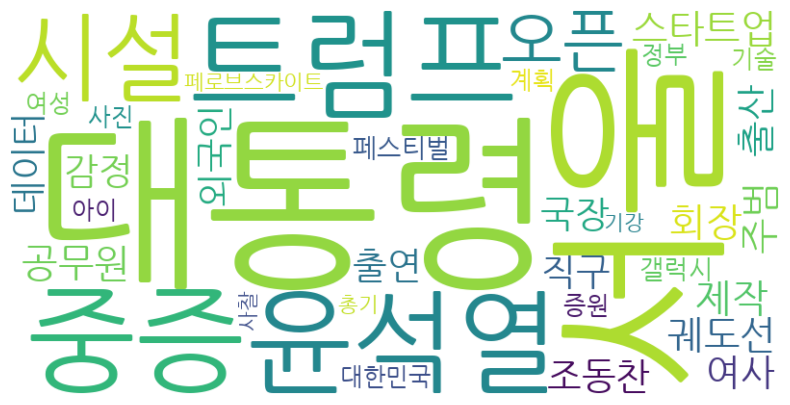

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import requests
import os

# Google Colab 환경에서 한글 폰트를 다운로드합니다.
!apt-get update -qq
!apt-get install fonts-nanum -qq

# 다운로드한 폰트 파일 경로를 지정합니다.
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'


# 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,  # 폰트 경로를 지정해야 합니다. Google Colab에서 한글 폰트 다운로드 필요
    width=800,
    height=400,
    background_color='white'
).generate(' '.join(all_keywords))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Topic Distribution:
Dominant_Topic
2    0.230769
0    0.205128
1    0.205128
3    0.179487
4    0.179487
Name: proportion, dtype: float64

Bias Score Mapping:
{2: 1, 0: 2, 1: 3, 3: 4, 4: 5}


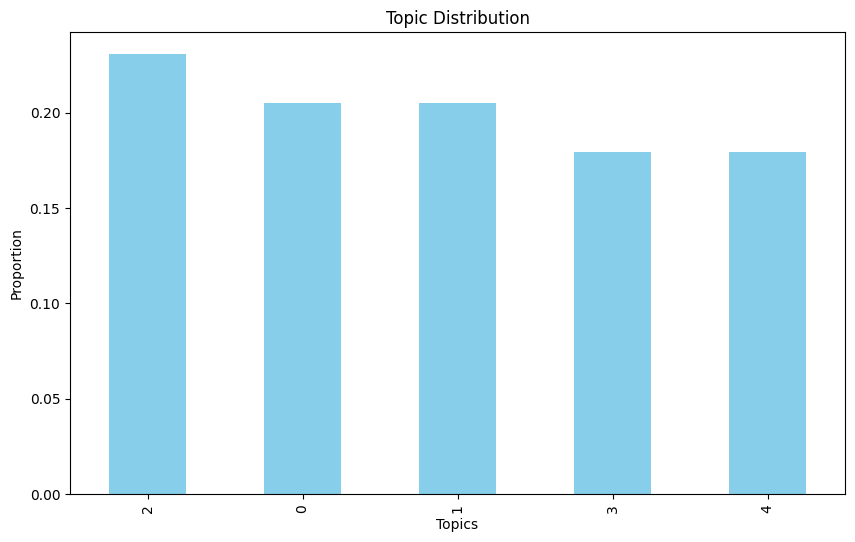

   Topic  Bias Score (1 to 5)
0      2                    1
1      0                    2
2      1                    3
3      3                    4
4      4                    5
Final DataFrame with Bias Scores:


,url,category,title,Bias Score (1 to 5)
0,https://n.news.naver.com/mnews/article/003/0012509031?sid=104,World,"""돈주고 불리한 기사 막았다"" 트럼프 성추문 재판 증언",1
1,https://n.news.naver.com/mnews/article/123/0002261234?sid=101,Economy,"오미크론 돌파감염, 백신효과 없나?...""중증예방 효과는 유지""",4
2,https://n.news.naver.com/article/081/0003449775?sid=100,Politics,윤 대통령 “아내 처신으로 걱정 끼쳐 사과…특검은 정치공세”,2
3,https://n.news.naver.com/mnews/article/586/0000071669?sid=102,Society,"20분 만에 떠난 尹-韓…""왜 왔나"" 서천시장 상인들 분노",5
4,https://n.news.naver.com/mnews/article/011/0004234555?sid=104,World,연천군 종합장사시설 설치 후보지 공모,3
5,https://n.news.naver.com/article/015/0004984365?sid=105,IT/Science,영화 'Her' 현실로…사람처럼 감정 담아 대화하는 AI 나온다,4
6,https://n.news.naver.com/mnews/article/277/0005150997?sid=101,Economy,"오뚜기, '스타트업 오픈 스테이지' 참가 기업 모집",4
7,https://n.news.naver.com/mnews/article/366/0000776450?sid=104,World,LS그룹 구자은號 출범… 9개사 CEO 교체,4
8,https://n.news.naver.com/mnews/article/018/0005071379?sid=103,Culture,용인시 소셜캐릭터 ‘조아용’ 만나보러 가볼까,1
9,https://n.news.naver.com/mnews/article/005/0001599840?sid=104,World,창업 아카데미·학자금 대출 이자 지원… 교회가 돕자,4


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from IPython.display import display

# 'all_nouns'가 이미 리스트 형태로 제공된다고 가정합니다.
# 예를 들어, all_nouns = [['word1', 'word2'], ['word3', 'word4'], ...]

# 기존 LDA 모델 코드
all_nouns = [content.split() for content in content_date_df['content']]
dictionary = corpora.Dictionary(all_nouns)
corpus = [dictionary.doc2bow(nouns) for nouns in all_nouns]
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=all_nouns):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])], axis=0)
            else:
                break
    sent_topics_df.reset_index(drop=True, inplace=True)
    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=all_nouns)

# 결합 전 인덱스를 재설정하여 문제 방지
content_date_df.reset_index(drop=True, inplace=True)
df_topic_sents_keywords.reset_index(drop=True, inplace=True)

content_date_df = pd.concat([content_date_df, df_topic_sents_keywords], axis=1)

# 편향성 지표 생성
if 'Dominant_Topic' in content_date_df.columns:
    topic_distribution = content_date_df['Dominant_Topic'].value_counts(normalize=True)
    print("Topic Distribution:")
    print(topic_distribution)
else:
    raise ValueError("Column 'Dominant_Topic' not found in content_date_df")

# 편향성 지표를 그대로 사용하여 1-5 점수로 변환
topic_to_score = {topic: (rank + 1) for rank, topic in enumerate(topic_distribution.index)}

content_date_df['Bias_Score'] = content_date_df['Dominant_Topic'].map(topic_to_score)

print("\nBias Score Mapping:")
print(topic_to_score)

plt.figure(figsize=(10, 6))
topic_distribution.plot(kind='bar', color='skyblue')
plt.title('Topic Distribution')
plt.xlabel('Topics')
plt.ylabel('Proportion')
plt.show()

bias_df = pd.DataFrame({
    'Topic': list(topic_to_score.keys()),
    'Bias Score (1 to 5)': list(topic_to_score.values())
})
print(bias_df)

# 결합 전 인덱스를 재설정하여 문제 방지
metadata_df.reset_index(drop=True, inplace=True)
content_date_df.reset_index(drop=True, inplace=True)

final_df = pd.concat([metadata_df, content_date_df[['Bias_Score']]], axis=1)
final_df.rename(columns={'Bias_Score': 'Bias Score (1 to 5)'}, inplace=True)

print("Final DataFrame with Bias Scores:")
display(final_df)

# 편향성이 가장 낮은 기사를 리스트로 뽑기
lowest_bias_articles = final_df[final_df['Bias Score (1 to 5)'] == final_df['Bias Score (1 to 5)'].min()]


In [ ]:
# Assume lowest_bias_articles contains the DataFrame with articles information

# Check if 'url' column exists in lowest_bias_articles DataFrame
if 'url' in lowest_bias_articles.columns:
    # Extract URLs from lowest_bias_articles DataFrame
    low_reliability_urls = lowest_bias_articles['url'].tolist()  # Replace 'url' with actual column name containing URLs

    # Print list of URLs
    print("List of URLs for articles with the lowest bias score:")
    for url in low_reliability_urls:
        print(url)

else:
    raise ValueError("Column 'url' not found in lowest_bias_articles DataFrame")


List of URLs for articles with the lowest bias score:
https://n.news.naver.com/mnews/article/003/0012509031?sid=104
https://n.news.naver.com/mnews/article/018/0005071379?sid=103
https://n.news.naver.com/mnews/article/081/0003197375?sid=103
https://n.news.naver.com/mnews/article/008/0004739154?sid=105
https://n.news.naver.com/mnews/article/009/0005044534?sid=101
https://n.news.naver.com/article/005/0001696904?sid=100
https://n.news.naver.com/mnews/article/421/0005153763?sid=104
https://n.news.naver.com/mnews/article/056/0011723764?sid=102
https://n.news.naver.com/mnews/article/047/0002337515?sid=104


<ipython-input-57-fc01af4ba3ee>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(final_df, x='Bias Score (1 to 5)', y='category', inner='stick', palette='Dark2')


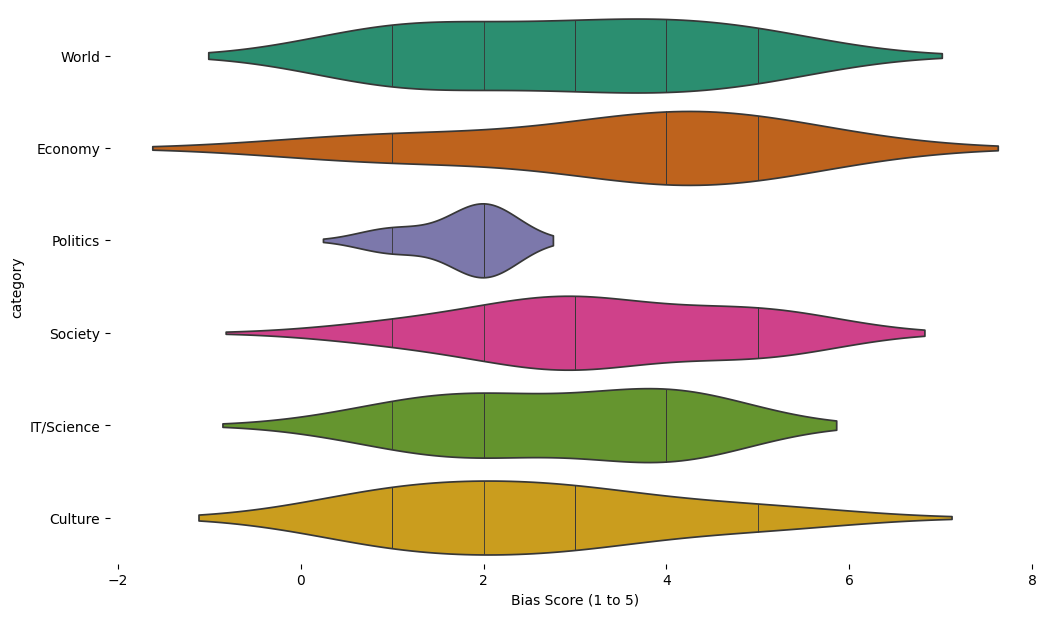

In [ ]:
# @title category vs Bias Score (1 to 5)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_df['category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_df, x='Bias Score (1 to 5)', y='category', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

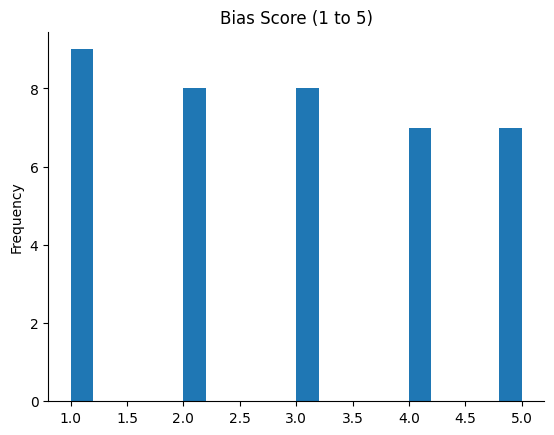

In [ ]:
# @title Bias Score (1 to 5)

from matplotlib import pyplot as plt
final_df['Bias Score (1 to 5)'].plot(kind='hist', bins=20, title='Bias Score (1 to 5)')
plt.gca().spines[['top', 'right',]].set_visible(False)

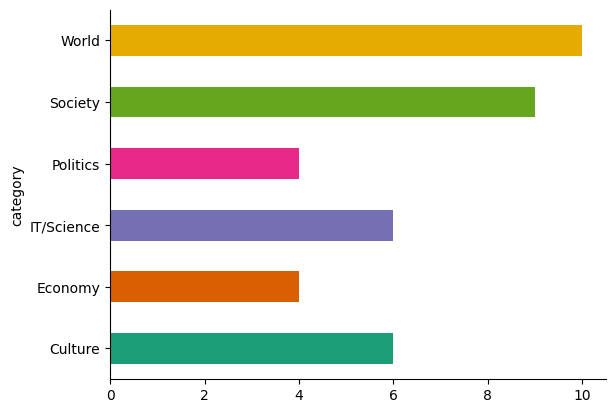

In [ ]:
# @title category

from matplotlib import pyplot as plt
import seaborn as sns
final_df.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

URL: https://n.news.naver.com/mnews/article/003/0012509031?sid=104
Title: "돈주고 불리한 기사 막았다" 트럼프 성추문 재판 증언
Reliability: 낮음
URL: https://n.news.naver.com/mnews/article/123/0002261234?sid=101
Title: 오미크론 돌파감염, 백신효과 없나?..."중증예방 효과는 유지"
Reliability: 중간
URL: https://n.news.naver.com/article/081/0003449775?sid=100
Title: 윤 대통령 “아내 처신으로 걱정 끼쳐 사과…특검은 정치공세”
Reliability: 중간
URL: https://n.news.naver.com/mnews/article/586/0000071669?sid=102
Title: 20분 만에 떠난 尹-韓…"왜 왔나" 서천시장 상인들 분노
Reliability: 낮음
URL: https://n.news.naver.com/mnews/article/011/0004234555?sid=104
Title: 연천군 종합장사시설 설치 후보지 공모
Reliability: 중간
URL: https://n.news.naver.com/article/015/0004984365?sid=105
Title: 영화 'Her' 현실로…사람처럼 감정 담아 대화하는 AI 나온다
Reliability: 높음
URL: https://n.news.naver.com/mnews/article/277/0005150997?sid=101
Title: 오뚜기, '스타트업 오픈 스테이지' 참가 기업 모집
Reliability: 중간
URL: https://n.news.naver.com/mnews/article/366/0000776450?sid=104
Title: LS그룹 구자은號 출범… 9개사 CEO 교체
Reliability: 중간
URL: https://n.news.naver.com/mnews/article/018

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45230 (\N{HANGUL SYLLABLE NAJ}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45458 (\N{HANGUL SYLLABLE NOP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


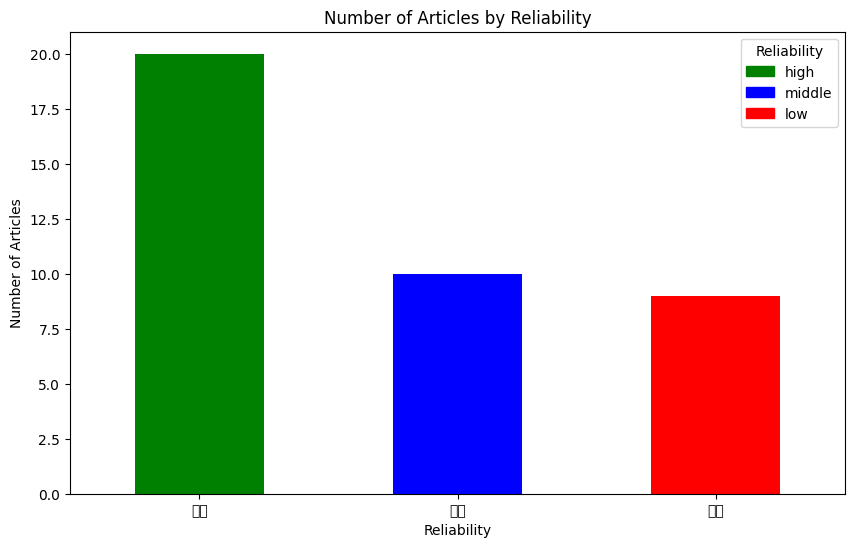


Articles with High Reliability:
URL: https://n.news.naver.com/article/015/0004984365?sid=105
URL: https://n.news.naver.com/mnews/article/018/0005071379?sid=103
URL: https://n.news.naver.com/mnews/article/023/0003684234?sid=104
URL: https://n.news.naver.com/mnews/article/055/0001058068?sid=102
URL: https://n.news.naver.com/mnews/article/008/0004739154?sid=105
URL: https://n.news.naver.com/mnews/article/001/0014381692?sid=105
URL: https://n.news.naver.com/mnews/article/003/0010412100?sid=103
URL: https://n.news.naver.com/mnews/article/031/0000729190?sid=105
URL: https://n.news.naver.com/mnews/article/421/0005153763?sid=104


In [ ]:
def extract_title_yna(soup):
    title_tag = soup.find('h1', {'class': 'tit'})
    return title_tag.get_text(strip=True) if title_tag else "제목을 찾을 수 없음"

def extract_content_yna(soup):
    content_tag = soup.find('div', {'class': 'story-news article'})
    if not content_tag:
        content_tag = soup.find('div', {'class': 'article-txt'})
    return content_tag.get_text(separator='\n', strip=True) if content_tag else "본문을 찾을 수 없음"

def extract_title_segye(soup):
    title_tag = soup.find('h1', {'class': 'headline'})
    return title_tag.get_text(strip=True) if title_tag else "제목을 찾을 수 없음"

def extract_content_segye(soup):
    content_tag = soup.find('div', {'id': 'article_txt'})
    return content_tag.get_text(separator='\n', strip=True) if content_tag else "본문을 찾을 수 없음"

def evaluate_reliability(title, content):
    keywords_positive = ['검증', '팩트체크', '신뢰도', '공식', '발표', '연구', '통계']
    keywords_negative = ['의혹', '논란', '주장', '미확인', '소문', '출처 불명', '카더라']

    score = 0
    for word in keywords_positive:
        if word in title or word in content:
            score += 1
    for word in keywords_negative:
        if word in title or word in content:
            score -= 1

    if score > 0:
        return "높음"
    elif score < 0:
        return "낮음"
    else:
        return "중간"

# 각 URL에서 데이터를 추출하여 두 개의 리스트에 저장
metadata_list = []
content_date_list = []
titles_seen = set()

for url in url_list:
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    category = get_category_from_url(url)
    if "yna.co.kr" in url:
        title = extract_title_yna(soup)
        content = extract_content_yna(soup)
    elif "segye.com" in url:
        title = extract_title_segye(soup)
        content = extract_content_segye(soup)
    else:
        title = extract_title(soup)
        content = extract_content(soup)

    date = extract_date(soup)
    reliability = evaluate_reliability(title, content)

    if title and "뉴스 : 네이버" not in title:
        if title not in titles_seen:
            metadata_list.append({'url': url, 'category': category, 'title': title, 'reliability': reliability})
            content_date_list.append({'content': content, 'date': date})
            titles_seen.add(title)
    else:
        if '제목을 찾을 수 없음' not in titles_seen:
            metadata_list.append({'url': url, 'category': category, 'title': '제목을 찾을 수 없음', 'reliability': '알 수 없음'})
            content_date_list.append({'content': '본문을 찾을 수 없음', 'date': '날짜를 찾을 수 없음'})
            titles_seen.add('제목을 찾을 수 없음')

# 결과 출력
for result in metadata_list:
    print(f"URL: {result['url']}")
    print(f"Title: {result['title']}")
    print(f"Reliability: {result['reliability']}")

# 신뢰도 결과를 데이터프레임으로 변환
reliability_df = pd.DataFrame(metadata_list)

# 신뢰도 등급별 기사 수를 세기
reliability_counts = reliability_df['reliability'].value_counts()

# 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
colors = ['green', 'blue', 'red']
reliability_counts.plot(kind='bar', color=colors)
plt.title('Number of Articles by Reliability')
plt.xlabel('Reliability')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)

# 범례 추가
labels = ['high', 'middle', 'low']
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
plt.legend(handles, labels, title='Reliability')

plt.show()

# 가장 신뢰도가 높은 기사들 리스트 출력
high_reliability_articles = reliability_df[reliability_df['reliability'] == '높음']
print("\nArticles with High Reliability:")
for idx, row in high_reliability_articles.iterrows():
    print(f"URL: {row['url']}")



In [ ]:
# Assume high_reliability_articles is the DataFrame containing articles with high reliability

# Extract URLs from high_reliability_articles DataFrame
high_reliability_urls = high_reliability_articles['url'].tolist()

# Print list of URLs
print("List of URLs for articles with high reliability:")
for url in high_reliability_urls:
    print(url)

List of URLs for articles with high reliability:
https://n.news.naver.com/article/015/0004984365?sid=105
https://n.news.naver.com/mnews/article/018/0005071379?sid=103
https://n.news.naver.com/mnews/article/023/0003684234?sid=104
https://n.news.naver.com/mnews/article/055/0001058068?sid=102
https://n.news.naver.com/mnews/article/008/0004739154?sid=105
https://n.news.naver.com/mnews/article/001/0014381692?sid=105
https://n.news.naver.com/mnews/article/003/0010412100?sid=103
https://n.news.naver.com/mnews/article/031/0000729190?sid=105
https://n.news.naver.com/mnews/article/421/0005153763?sid=104


In [ ]:
import webbrowser

# Assume high_reliability_urls and low_reliability_urls are lists of URLs

# Find common URLs
common_urls = list(set(high_reliability_urls) & set(low_reliability_urls))

# Print list of common URLs
print("Common URLs:")
for url in common_urls:
    print(url)

# Open each common URL in a web browser tab
for url in common_urls:
    webbrowser.open_new_tab(url)


Common URLs:
https://n.news.naver.com/mnews/article/018/0005071379?sid=103
https://n.news.naver.com/mnews/article/008/0004739154?sid=105
https://n.news.naver.com/mnews/article/421/0005153763?sid=104
